In [ ]:
# (c) 2024 Viktor Nilsson

# Gaussian process classification with Laplace approximation

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [ ]:
def gaussian_kernel(x, y, l=1):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * l**2))

my_kernel = lambda x, y: gaussian_kernel(x, y, l=0.2)

In [ ]:
X = np.linspace(-5, 5, 1000)

m = np.zeros(len(X))
K = np.zeros((len(X), len(X)))

for i in range(len(X)):
    for j in range(len(X)):
        K[i, j] = my_kernel(X[i], X[j])

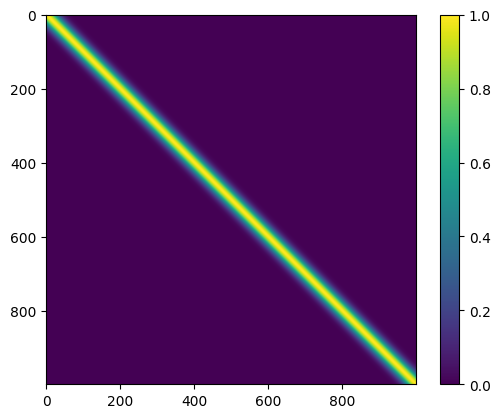

In [ ]:
plt.imshow(K)

plt.colorbar()
#plt.xticks(np.linspace(0, 100, 5), np.linspace(-5, 5, 5))
plt.show()

 Sample some functions from our GP-prior

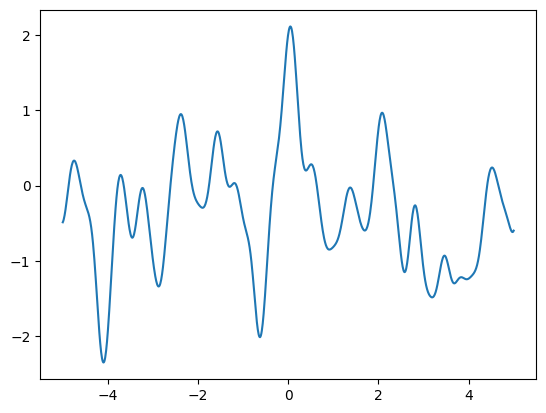

In [ ]:
f_X = np.random.multivariate_normal(m, K)

plt.plot(X, f_X)#, 'o')
plt.show()

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

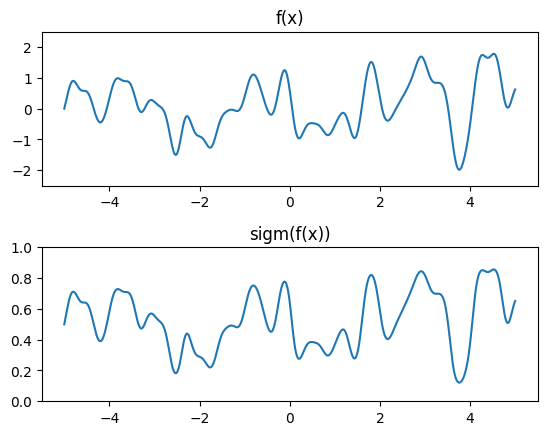

In [ ]:
f_X = np.random.multivariate_normal(m, K)

plt.figure()
plt.subplot(211)
plt.plot(X, f_X)
plt.title('f(x)')
plt.ylim(-2.5, 2.5)
plt.subplots_adjust(hspace=0.4)
plt.subplot(212)
plt.plot(X, sigmoid(f_X))
plt.title('sigm(f(x))')
plt.ylim(0, 1.0)
#plt.plot(X, f_X)
#plt.plot(X, sigmoid(f_X))
plt.show()

In [ ]:
# Observed data

X_obs = np.array([-4, -3, -2.5, -2, -1, 1, 1.5, 2])
y_obs = np.array([1, -1, -1, -1, 1, 1, 1, 1])

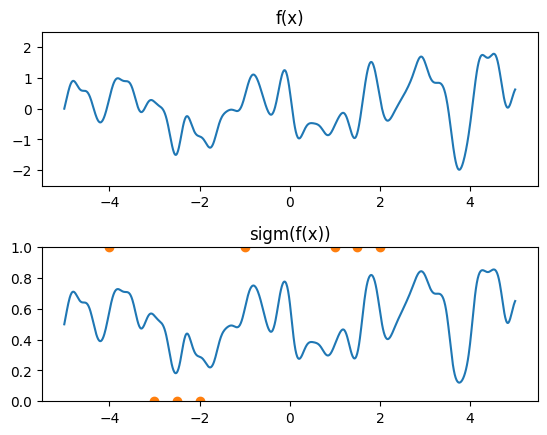

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(X, f_X)
plt.title('f(x)')
plt.ylim(-2.5, 2.5)
plt.subplots_adjust(hspace=0.4)
plt.subplot(212)
plt.plot(X, sigmoid(f_X))
plt.title('sigm(f(x))')
plt.ylim(0, 1.0)

plt.plot(X_obs, 0.5 + 0.5*y_obs, 'o')

plt.show()

# Inference
 Now let us condition on $Y = y$ and do Bayesian inference.
 Use a zero-mean GP-prior like below, and find the $a^{MAP}$ like in lecture

In [ ]:
my_kernel = lambda x, y: 2.0 * gaussian_kernel(x, y, l=0.8)

K_obs = np.zeros((len(X_obs), len(X_obs)))

for i in range(K_obs.shape[0]):
    for j in range(K_obs.shape[1]):
        K_obs[i,j] = my_kernel(X_obs[i], X_obs[j])

 Negative log-likelihood functions

In [ ]:
def nll(a):
    return 1/2 * np.linalg.solve(K_obs, a) @ a - np.sum(np.log(sigmoid(y_obs * a)))

def gradient(a):
    return np.linalg.solve(K_obs, a) - (1 - sigmoid(y_obs * a)) * y_obs

def W(a):
    return np.diag(sigmoid(y_obs * a) * (1 - sigmoid(y_obs * a)))

#def hessian(a) = ... don't need, unless doing Newton

 Optimization

In [ ]:
# Start optimization at 0
a_0 = np.zeros(len(X_obs))

n_steps = 1000
stepsize = 0.01
a = a_0
np.set_printoptions(formatter={'float': lambda x: "{0:0.2E}".format(x)})
print(f"{nll(a):.5f}, {gradient(a)}")

for i in range(n_steps):
    a -= stepsize * gradient(a)
    #print(f"{nll(a):.8f}, {gradient(a)}")

a_MAP = a

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"{a_MAP=}")
np.set_printoptions(formatter={'float': lambda x: "{0:0.2E}".format(x)})
print(f"grad(a_MAP) = {gradient(a_MAP)}")

5.54518, [-5.00E-01 5.00E-01 5.00E-01 5.00E-01 -5.00E-01 -5.00E-01 -5.00E-01
 -5.00E-01]
a_MAP=array([0.421, -0.844, -1.162, -0.846, 0.438, 1.099, 1.242, 1.071])
grad(a_MAP) = [1.95E-03 5.31E-03 6.06E-03 5.28E-03 1.71E-03 -7.78E-03 -9.06E-03
 -7.77E-03]


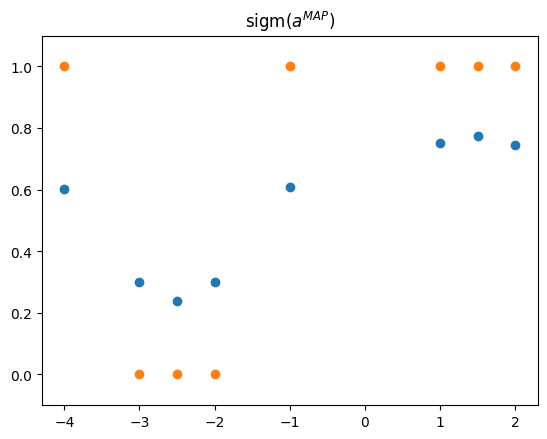

In [ ]:
plt.figure()
plt.plot(X_obs, sigmoid(a_MAP), 'o')
plt.title('sigm($a^{MAP}$)')
plt.ylim(-0.1, 1.1)

plt.plot(X_obs, 0.5 + 0.5*y_obs, 'o')

plt.show()

In [ ]:
# Posterior for f(x') now, over 'all' x'

X_p = np.linspace(-5, 5, 1000)

#k(x', x')
K_pp = np.zeros((len(X_p), len(X_p)))
for i in range(K_pp.shape[0]):
    for j in range(K_pp.shape[1]):
        K_pp[i, j] = my_kernel(X_p[i], X_p[j])

#k(x', x)
K_p = np.zeros((len(X_p), len(X_obs)))
for i in range(K_p.shape[0]):
    for j in range(K_p.shape[1]):
        K_p[i, j] = my_kernel(X_p[i], X_obs[j])

In [ ]:
# Compute the posterior parameters for f(x')

m_1 = K_p @ np.linalg.solve(K_obs, a_MAP)
Sigma_11 = K_pp - K_p @ np.linalg.solve((np.diag(1 / np.diag(W(a_MAP))) + K_obs), K_p.T)

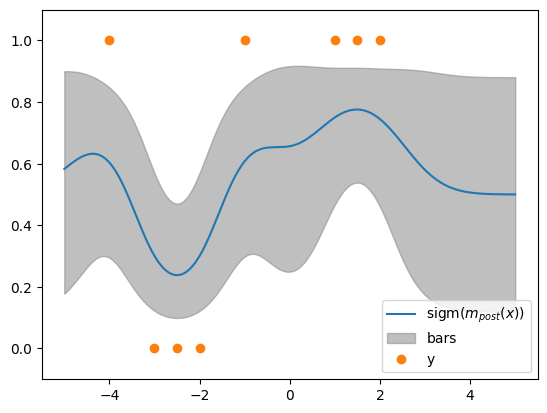

In [ ]:
plt.figure()
plt.plot(X_p, sigmoid(m_1))
plt.fill_between(X_p, sigmoid(m_1 - np.diag(Sigma_11)), sigmoid(m_1 + np.diag(Sigma_11)), color='gray', alpha=0.5)

plt.ylim(-0.1, 1.1)

plt.plot(X_obs, 0.5 + 0.5*y_obs, 'o')

plt.legend(['sigm($m_{post}(x)$)', 'bars', 'y'], loc='lower right')

plt.show()

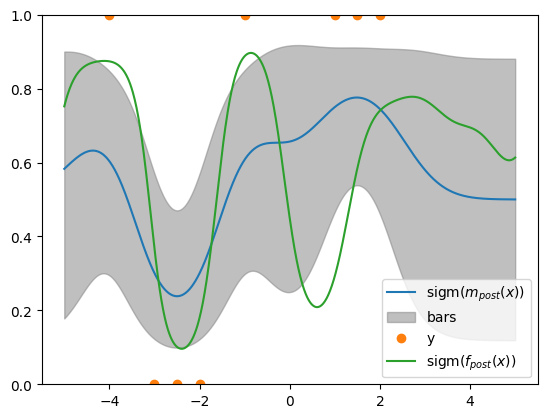

In [ ]:
# Run several times to see different posterior samples sigm(f_post)

plt.figure()
plt.plot(X_p, sigmoid(m_1))
plt.fill_between(X_p, sigmoid(m_1 - np.diag(Sigma_11)), sigmoid(m_1 + np.diag(Sigma_11)), color='gray', alpha=0.5)

plt.ylim(0, 1.0)

plt.plot(X_obs, 0.5 + 0.5*y_obs, 'o')

f_post_sample = np.random.multivariate_normal(m_1, Sigma_11)
plt.plot(X_p, sigmoid(f_post_sample))

plt.legend(['sigm($m_{post}(x)$)', 'bars', 'y', 'sigm($f_{post}(x)$)'], loc='lower right')

plt.show()

 Marginal posterior predictive distributions with probit approximation

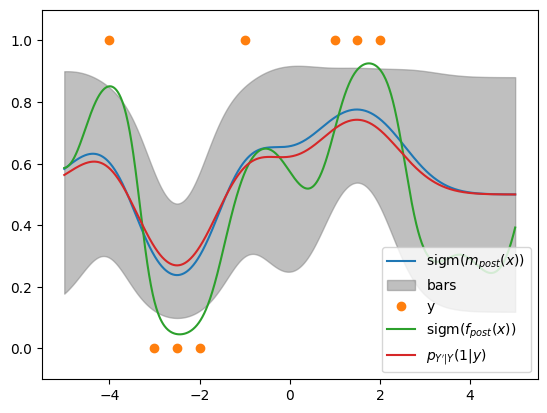

In [ ]:
lamb = np.sqrt(np.pi / 8)

# Alt. use sigmoid(. / lambda) here
probits = norm.cdf(m_1 / (lamb ** (-2) + np.diag(Sigma_11))**(1/2))

plt.figure()
plt.plot(X_p, sigmoid(m_1))
plt.fill_between(X_p, sigmoid(m_1 - np.diag(Sigma_11)), sigmoid(m_1 + np.diag(Sigma_11)), color='gray', alpha=0.5)

plt.ylim(-0.1, 1.1)

plt.plot(X_obs, 0.5 + 0.5*y_obs, 'o')

f_post_sample = np.random.multivariate_normal(m_1, Sigma_11)
plt.plot(X_p, sigmoid(f_post_sample))

plt.plot(X_p, probits)

plt.legend(['sigm($m_{post}(x)$)', 'bars', 'y', 'sigm($f_{post}(x)$)', "$p_{Y'|Y}(1|y)$"], loc='lower right')

plt.show()

# Further ideas
 A list of additional things that you can play with.
 - Other kernels, e.g. Brownian motion, exponential
 - Implement this on a 2D example, e.g. the two moons dataset
 - Hyperparameter optimization (empirical Bayes)
 - Use Newton's method to get $a^{MAP}$, should be more stable
 - Plot decision boundaries for different losses functions
 - Multi-class GP classifier with Laplace approximation